# Code implementation (python)

---

__Sampling phase__
- $y = \Phi x$, simulate what would happen on device (_compute block by block, later concatenate results_)

---

__Recovery phase__
- Reconstruct $\hat{s}$, approximation of $s$ _sparse representation_ of $x$
- Use dictionary $\Psi$ to retrieve $\hat{x}$ approximation of $x$ 

--- 

__Evaluate result__
1. Sampling faster for smaller $\Phi$?
2. Which dictionary are the best? (How fast, how accurate)
3. With Kronecker vs without
4. ~~Which recovery method is best? (How fast, how accurate)~~ only use Smooth-L0
5. ~~Robustness to noise?~~

---

## Code: sampling phase

### Measurement matrix $\Phi$

In [51]:
import numpy as np

def generate_measurement_matrix(rows, cols):
    """
    Generates a random measurement matrix with the specified number of rows and columns.

    Parameters:
    - rows (int): The number of rows in the measurement matrix.
    - cols (int): The number of columns in the measurement matrix.

    Returns:
    - numpy.ndarray: The generated measurement matrix with shape (rows, cols).

    Description:
    This function generates a random measurement matrix with the specified number of rows and columns. 
    The measurement matrix is created by randomly choosing either -1 or 1 for each element in the matrix.
    The resulting matrix is returned as a numpy array.
    """
    
    np.random.seed(42)  # Set the seed for reproducibility (comment out if not needed)

    return np.random.choice([-1, 1], size=(rows, cols))


### Signal Sampling $y = \Phi x$

In [52]:
import numpy as np

def compute_compressed_measurement(signal, signal_block_dimension):
    """
    Computes the compressed measurement of a signal using compressed sensing.

    Parameters:
    - signal (numpy.ndarray): The input signal.
    - signal_block_dimension (int): The dimension of each signal block.

    Returns:
    - numpy.ndarray: The compressed measurement of the signal.
    - numpy.ndarray: The measurement matrix used for compression.

    Description:
    This function computes the compressed measurement of a signal using compressed sensing.
    It generates a measurement matrix with the specified number of columns based on the signal block dimension.
    Then, it computes the compressed measurement block by block and concatenates the results to obtain the compressed measurement of the whole signal.
    The resulting compressed measurement and measurement matrix are returned as numpy arrays.
    """

    # Number of complete blocks
    NUM_BLOCKS = len(signal) // signal_block_dimension

    # To achieve 75% compression rate: the number of rows in the measurement matrix is set to 1/4 of the signal block dimension
    NUM_OF_ROWS = signal_block_dimension // 4

    # Generate measurement matrix using your existing function
    measurement_matrix = generate_measurement_matrix(NUM_OF_ROWS, signal_block_dimension)


    # Initialize list to store compressed measurement blocks
    compressed_measurement_blocks = []

    # Compute the compressed measurement block by block
    for i in range(NUM_BLOCKS):
        
        # Get the current block of the signal
        block = signal[i * signal_block_dimension : (i + 1) * signal_block_dimension]

        # Compute the compressed measurement block
        compressed_measurement_block = measurement_matrix @ block

        # Append the compressed measurement block to the list
        compressed_measurement_blocks.append(compressed_measurement_block)

    # Concatenate all blocks into a single 1D array
    compressed_measurement = np.concatenate(compressed_measurement_blocks)

    return compressed_measurement, measurement_matrix


## Code: recovery phase

The only two things needed out of the _sampling phase_ are $y$ and $\Phi$

Next step is to solve:
$$
\hat{s} = \arg_{s} \min \|s\|_1 \text{ subject to } y = \Phi \Psi \alpha
$$

### Matrix $\Theta = \Phi \Psi$ for fixed dictionaries

It's necessary to compute $\Theta = \Phi \Psi$
- First possibility is to actually compute the dictionary $\Psi$
- It's not efficient to compute the whole base $\Psi$, it's preferable a _matrix-free_ approach
- We should allow choosing various __fixed dictionaries__
- We need to store what transform we used in order to successfully reconstruct in later steps

In [53]:
import numpy as np
from scipy.fftpack import dct
from pywt import wavedec, waverec

def create_psi_matrix(n, transform_type='wavelet', wavelet='db4', level=None):
    """
    Constructs the Psi matrix of size (n, n) based on the specified transform type.
    
    Parameters:
    - n (int): The dimension of the Psi matrix (n x n).
    - transform_type (str): The type of transform to use. Can be 'wavelet' (default) or 'dct'.
    - wavelet (str): The type of wavelet to use for DWT. Default is 'db4'.
    - level (int or None): The decomposition level (used only for wavelet).
    
    Returns:
    - numpy.ndarray: The Psi matrix of shape (n, n).
    """
    if transform_type == 'wavelet':
        psi = np.zeros((n, n))
        for ii in range(n):
            ek = np.zeros(n)
            ek[ii] = 1
            coeffs = wavedec(ek, wavelet, level=level)
            psi_row = waverec(coeffs, wavelet)[:n]
            psi[ii, :] = psi_row

    elif transform_type == 'dct':
        # Create the DCT matrix where each row is a DCT basis function
        psi = dct(np.eye(n), norm='ortho')

    else:
        raise ValueError("transform_type must be either 'wavelet' or 'dct'")
    
    return psi

In [54]:
import numpy as np
from scipy.fftpack import idct
from pywt import wavedec, waverec


def compute_theta(phi, transform_type='wavelet', wavelet='db4', level=None):
    """
    Computes the matrix Theta = Phi * Psi using the specified transform type 
    (either wavelet or DCT) and returns the computed Theta matrix along with 
    the Psi matrix (the basis matrix).

    Parameters:
    - phi (numpy.ndarray): The measurement matrix Phi of shape (m, n), where 
      m is the number of measurements and n is the length of the signal block.
    - transform_type (str): The type of transform to use for constructing the Psi matrix. 
      Can be 'wavelet' (default) or 'dct'.
    - wavelet (str): The type of wavelet to use for the wavelet transform. 
      Default is 'db4'. This parameter is only used if transform_type='wavelet'.
    - level (int or None): The decomposition level for the wavelet transform. 
      If None, the maximum possible level is used. This parameter is only used 
      if transform_type='wavelet'.

    Returns:
    - tuple: (Theta, Psi)
      - Theta (numpy.ndarray): The matrix Theta of shape (m, n), where 
        Theta = Phi * Psi. Theta represents the measurement matrix multiplied 
        by the transform basis matrix.
      - Psi (numpy.ndarray): The transform basis matrix Psi of shape (n, n), 
        constructed using the specified transform (wavelet or DCT).

    Raises:
    - ValueError: If an invalid transform_type is provided.
    """

    # Number of columns in the measurement matrix (length of signal block)
    n = phi.shape[1]

    # Create the Psi matrix using chosen transform type
    if transform_type == 'wavelet':
        psi = create_psi_matrix(n, transform_type='wavelet', wavelet=wavelet, level=level)
    elif transform_type == 'dct':
        psi = create_psi_matrix(n, transform_type='dct')
    else:
        raise ValueError("transform_type must be either 'wavelet' or 'dct")
    
    return phi @ psi, psi



def compute_theta_matrixFree(phi, transform_type='dwt', wavelet='db4'):
    """
    Computes the matrix Theta = Phi * Psi using a matrix-free approach with the DCT or DWT as the basis for Psi.
    Also returns the transform type and wavelet type (if applicable).

    Parameters:
    - phi (numpy.ndarray): The measurement matrix Phi of shape (m, n).
    - transform_type (str): The type of transform to use. Can be 'dwt' (default) or 'dct'.
    - wavelet (str): The type of wavelet to use for DWT. Default is 'db4'.

    Returns:
    - tuple: (Theta, transform_type, wavelet_type)
      - Theta (numpy.ndarray): The matrix Theta of shape (m, n), where Theta = Phi * Psi.
      - transform_type (str): A string indicating the transform used ('dct' or 'dwt').
      - wavelet_type (str or None): The wavelet name if DWT is used; None if DCT is used.
    """

    # Get the number of columns of Phi, equal to signal block dimension
    n = phi.shape[1]

    # Initialize Theta as a zero matrix of shape (m, n)
    m = phi.shape[0]
    theta = np.zeros((m, n))

    # Set the wavelet_type to None initially
    wavelet_type = None

    # Iteratively compute each column of Theta
    for ii in range(n):
        # Create the unit vector ek
        ek = np.zeros(n)
        ek[ii] = 1

        # Compute the corresponding column of Psi using the chosen transform
        if transform_type == 'dct':
            psi_column = idct(ek, norm='ortho')
        elif transform_type == 'dwt':
            # Decompose the unit vector in the wavelet domain
            coeffs = wavedec(ek, wavelet, level=1)
            # Reconstruct the unit vector (basis vector) in the time domain
            psi_column = waverec(coeffs, wavelet)[:n]
            wavelet_type = wavelet  # Set the wavelet_type to the specified wavelet

        # Compute the corresponding column of Theta
        theta[:, ii] = np.dot(phi, psi_column)

    return theta, transform_type, wavelet_type


### Reconstruction Methods

#### LASSO

In [55]:
import numpy as np
from sklearn.linear_model import Lasso

def lasso_sparse_representation(y, theta, alpha=0.1, max_iter=1000):
    """
    Finds the sparse representation s_hat given y and Theta using LASSO.

    Parameters:
    - y (numpy.ndarray): The compressed measurement vector of shape (m,).
    - Theta (numpy.ndarray): The matrix Theta of shape (m, n) where Theta = Phi * Psi.
    - alpha (float): Regularization strength; must be a positive float. Default is 0.1.
    - max_iter (int): The maximum number of iterations for the LASSO solver. Default is 1000.

    Returns:
    - numpy.ndarray: The estimated sparse representation s_hat of shape (n,).
    """

    # Initialize the LASSO model
    lasso = Lasso(alpha=alpha, max_iter=max_iter)

    # Fit the model to find the sparse representation
    lasso.fit(theta, y)

    # Get the estimated sparse representation
    s_hat = lasso.coef_

    return s_hat



### Reconstruction

In [56]:
import numpy as np

def reconstruct_signal(y, phi, alpha=0.1, max_iter=1000, transform_type='wavelet', wavelet='db4', level=None):
    """
    Reconstructs the original signal from compressed measurements using a block-based approach and LASSO for sparse recovery.
    
    Parameters:
    - y (numpy.ndarray): The compressed measurement vector of shape (m,), where m is the total number of measurements.
    - phi (numpy.ndarray): The measurement matrix Phi of shape (BLOCK_SIZE, n), where BLOCK_SIZE is the number of measurements per block and n is the length of each signal block.
    - alpha (float): Regularization strength for the LASSO solver. Default is 0.1.
    - max_iter (int): Maximum number of iterations for the LASSO solver. Default is 1000.
    - transform_type (str): The type of transform to use for constructing the Psi matrix. Can be 'wavelet' (default) or 'dct'.
    - wavelet (str): The type of wavelet to use for the wavelet transform. Default is 'db4'. This is only used if transform_type='wavelet'.
    - level (int or None): The decomposition level for the wavelet transform. If None, the maximum possible level is used. This is only used if transform_type='wavelet'.

    Returns:
    - numpy.ndarray: The reconstructed signal, concatenated from all blocks.
    """

    # Compute Theta and Psi matrices
    theta, psi = compute_theta(phi, transform_type, wavelet, level)

    # Define block size, it should be equal to the number of rows in the measurement matrix
    BLOCK_SIZE = phi.shape[0]

    # Calculate the number of complete blocks that fit into y
    num_complete_blocks = len(y) // BLOCK_SIZE

    # Reconstruct each block of the signal and concatenate them
    x_blocks = []
    for ii in range(num_complete_blocks):
        start_idx = ii * BLOCK_SIZE
        end_idx = start_idx + BLOCK_SIZE
        y_block = y[start_idx:end_idx]
        s_block = lasso_sparse_representation(y_block, theta, alpha, max_iter)
        x_block = psi @ s_block
        x_blocks.append(x_block)

    # Concatenate all blocks to form the full reconstructed signal
    x = np.concatenate(x_blocks)

    return x


## Code: reconstructed signal evaluation

In [57]:
import numpy as np

def calculate_prd(original_signal, reconstructed_signal):
    """
    Calculate the Percentage Root Mean Square Difference (PRD).
    
    Parameters:
    original_signal (np.array): The original ECG signal.
    reconstructed_signal (np.array): The reconstructed ECG signal.
    
    Returns:
    float: The PRD value as a percentage.
    """
    numerator = np.sum((original_signal - reconstructed_signal) ** 2)
    denominator = np.sum(original_signal ** 2)
    prd = 100 * np.sqrt(numerator / denominator)
    return prd

def calculate_snr(prd):
    """
    Calculate the Signal-to-Noise Ratio (SNR) based on PRD.
    
    Parameters:
    prd (float): The PRD value as a percentage.
    
    Returns:
    float: The SNR value in dB.
    """
    snr = -20 * np.log10(prd / 100)
    return snr

In [58]:
import numpy as np
import matplotlib.pyplot as plt

def plot_and_evaluate_reconstruction(original_signal, reconstructed_signal):
    """
    Plots the original signal over the reconstructed signal and evaluates the reconstruction 
    using Percentage Root Mean Square Difference (PRD) and Signal-to-Noise Ratio (SNR).
    
    Parameters:
    - original_signal (np.array): The original ECG signal.
    - reconstructed_signal (np.array): The reconstructed ECG signal.
    
    Returns:
    - tuple: (prd, snr)
      - prd (float): The PRD value as a percentage.
      - snr (float): The SNR value in dB.
    """
    # Plotting the signals
    plt.figure(figsize=(10, 6))
    plt.plot(original_signal, label='Original Signal')
    plt.plot(reconstructed_signal, label='Reconstructed Signal', linestyle='--')
    plt.title("Original vs Reconstructed Signal")
    plt.xlabel("Sample Index")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Calculate PRD
    prd = calculate_prd(original_signal, reconstructed_signal)
    print(f"PRD (Percentage Root Mean Square Difference): {prd:.2f}%")
    
    # Calculate SNR
    snr = calculate_snr(prd)
    print(f"SNR (Signal-to-Noise Ratio): {snr:.2f} dB")
    
    return prd, snr

## Code: test for best dictionary

- Test all dictionaries to show with big number of data which are the one to perform better (we expect DWT to be the best of fixed, and that adaptive are better than fixed in general)
- __#Records:__ Test on __MULTIPLE patients__ records is a MUST, especially to show that adaptive are better 
- __#Dictionaries:__ Test all dictionaries, that's what we are doing ...
- __#ReconstructionMethods:__ Test with __only one reconstruction method__

## Code: test for best reconstruction method

- Test to find which recontruction method is the best
- __#Records:__ Test on a __single patient__ record should be fine 
- __#Dictionaries:__ Test with __a single dictionary type__
- __#ReconstructionMethods:__ Test with __all reconstruction methods__

## Code: test for correct block dimension

- Test to show that __sampling phase process speed is inversly proportional to block dimension__
- __#Records:__ Test on a __single patient__ record should be fine 
- __#Dictionaries:__ Test with __a single dictionary type__ (USE BEST!)
- __#ReconstructionMethods:__ Test with __only one reconstruction method__ (USE BEST!)

## Code: test for noise robustness

- Test if robust to noise by adding noise to the signal
- __#Records:__ Test on a __single patient__ record should be fine 
- __#Dictionaries:__ Test with __a single dictionary type__ (USE BEST!)
- __#ReconstructionMethods:__ Test with __only one reconstruction method__ (USE BEST!)

# Data: MIT–BIH Arrhythmia Database

### MIT-BIH Arrhythmia Database

__Source:__ [physionet.org](https://www.physionet.org/content/mitdb/1.0.0/)

__Authors:__ George Moody, Roger Mark

__Version:__ 1.0.0 (Feb. 24, 2005)

__Citation Information__

__Original publication:__
Moody GB, Mark RG. *The impact of the MIT-BIH Arrhythmia Database*. IEEE Eng in Med and Biol 20(3):45-50 (May-June 2001). (PMID: 11446209)

__Citation for PhysioNet:__
Goldberger, A., Amaral, L., Glass, L., Hausdorff, J., Ivanov, P. C., Mark, R., ... & Stanley, H. E. (2000). *PhysioBank, PhysioToolkit, and PhysioNet: Components of a new research resource for complex physiologic signals*. Circulation [Online]. 101 (23), pp. e215–e220.

__Background__

Since 1975, laboratories at Boston’s Beth Israel Hospital (now the Beth Israel Deaconess Medical Center) and at MIT have supported research into arrhythmia analysis and related subjects. One of the first major products of that effort was the MIT-BIH Arrhythmia Database, completed and distributed in 1980. The database was the first generally available set of standard test material for evaluating arrhythmia detectors and has been used for that purpose as well as for basic research into cardiac dynamics at more than 500 sites worldwide. Originally, the database was distributed on 9-track half-inch digital tape at 800 and 1600 bpi, and on quarter-inch IRIG-format FM analog tape. In August 1989, a CD-ROM version of the database was produced.

__Data Description__

The MIT-BIH Arrhythmia Database contains:

- 48 half-hour excerpts of __two-channel ambulatory ECG recordings.__
- Data obtained from 47 subjects (1975-1979).
- 23 recordings chosen at random from a set of 4000 24-hour ambulatory ECG recordings from Boston’s Beth Israel Hospital (inpatients 60%, outpatients 40%).
- 25 recordings selected to include less common but clinically significant arrhythmias.
- __Digitized at 360 samples per second per channel with 11-bit resolution over a 10 mV range.__
- Annotations by two or more cardiologists; disagreements resolved to obtain reference annotations (approx. 110,000 annotations).


### Download the database

In [59]:
# Downloading the database (command worked on August 2024, otherwise look for the database on physionet.org)

# This will ignore:
# mitdbdir: html where data is presented and explained (go on website if intrested or download without "--exclude" option)
# *.xws: files that are used to visualize data on a Physionet.org tool called "LightWave" (go on website if intrested or download without "--reject" option)

#!wget -r -N -c -np --reject "*.xws" --exclude-directories=mitdbdir https://physionet.org/files/mitdb/1.0.0/



### Step 1: Retrieving the Data Path

To read the MITDB (MIT-BIH Arrhythmia Database) data using the `wfdb` library, we first need to retrieve the data path. In this Jupyter Notebook, the data path is stored in the `data_folder` variable.
We can use this path to locate the specific record we want to read. In this case, the record number is stored in the `record_number` variable.

To construct the full path to the record, we can use the `os.path.join()` function as follows:



In [60]:
import os

# Define the project root directory (assuming the notebook is in the root directory)
project_root = os.getcwd()  # Gets the current working directory, which is the root in this case

# Define the relative path to the data folder
data_folder = os.path.join(project_root, 'physionet.org', 'files', 'mitdb', '1.0.0')

# Specify the record number
record_number = '100'  # Change this to the desired record number

# Construct the full path to the record
record_path = os.path.join(data_folder, record_number)


# print record_path
print(record_path)


/home/franco/Dropbox/AA_Fra_Rosnati/B_Education/AA_University/AA_PoliMi/AA_Ing/01_Magistrale/HPC_engineering/1_sem_HPC/NAML/NAML_project/NAML_ECG_compressor/physionet.org/files/mitdb/1.0.0/100


### Step 2: Load the signal and annotations
In the code above, we first import the `wfdb` module. Then, we use the `rdrecord()` function to load the signal from the specified `record_path`. We also use the `rdann()` function to load the annotations for the same record. 

After executing this code, the signal will be stored in the `record` variable, and the annotations will be stored in the `annotation` variable.

We will then visualize the whole signal, it's unreadable on a 30 hours time frame, it's only to visually check if downloading went well.

In [61]:
import wfdb

# Load the signal and annotations
record = wfdb.rdrecord(record_path)
annotation = wfdb.rdann(record_name=record_path, extension='atr', shift_samps=True)


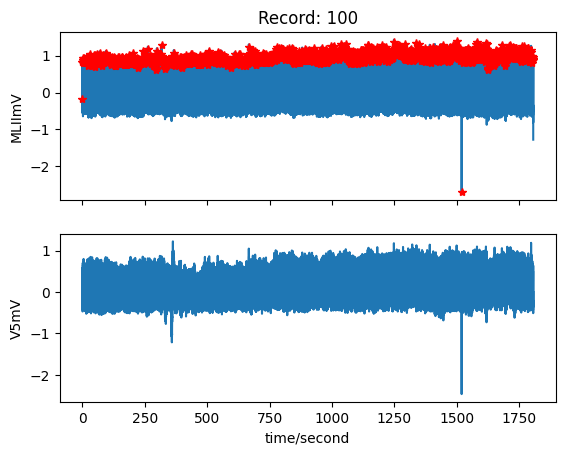

In [62]:
# Plot the signal with annotations, just to check if download went correctly
wfdb.plot_wfdb(record=record, annotation=annotation)

### Step 3: moving data to Pandas dataframe
Simply use the proper function from `wfdb` library

__Annotation will not be ported to pandas dataframe__

In [63]:
import pandas as pd
df = record.to_dataframe()

print(df.head(15))
print("\n")
print(df.dtypes)

                            MLII     V5
0 days 00:00:00           -0.145 -0.065
0 days 00:00:00.002777777 -0.145 -0.065
0 days 00:00:00.005555554 -0.145 -0.065
0 days 00:00:00.008333331 -0.145 -0.065
0 days 00:00:00.011111108 -0.145 -0.065
0 days 00:00:00.013888885 -0.145 -0.065
0 days 00:00:00.016666662 -0.145 -0.065
0 days 00:00:00.019444439 -0.145 -0.065
0 days 00:00:00.022222216 -0.120 -0.080
0 days 00:00:00.024999993 -0.135 -0.080
0 days 00:00:00.027777770 -0.145 -0.085
0 days 00:00:00.030555547 -0.150 -0.085
0 days 00:00:00.033333324 -0.160 -0.075
0 days 00:00:00.036111101 -0.155 -0.070
0 days 00:00:00.038888878 -0.160 -0.070


MLII    float64
V5      float64
dtype: object


## PART II: visualize the ECG data

The ECG wave consists of three main components: the P wave, the QRS complex, and the T wave.

- The P wave represents atrial depolarization, which is the contraction of the atria. It is typically a small and smooth upward deflection.
- The QRS complex represents ventricular depolarization, which is the contraction of the ventricles. It consists of three distinct waves: Q, R, and S. The Q wave is the first downward deflection, the R wave is the first upward deflection after the Q wave, and the S wave is the downward deflection after the R wave.
- The T wave represents ventricular repolarization, which is the recovery of the ventricles. It is typically a smooth upward deflection.

The typical duration of the P wave is around 80-100 milliseconds, the QRS complex lasts around 80-120 milliseconds, and the T wave lasts around 160-240 milliseconds.

The distance between waves can vary depending on the heart rate. In a normal sinus rhythm, the distance between consecutive P waves (P-P interval) is usually consistent and represents the atrial rate. The distance between consecutive R waves (R-R interval) represents the ventricular rate. The normal range for the R-R interval is around 600-1000 milliseconds.

When plotting hours-long ECG data, the waves become densely packed, making it difficult to interpret the waveform patterns. To overcome this, we can plot a specific interval of the ECG data by selecting a starting time and duration. This allows us to focus on a specific part of the ECG waveform and make it more interpretable.

This can be useful when deciding portion of data to work on

In [64]:
import matplotlib.pyplot as plt

def plot_ecg_interval(df, start_sample=0, num_samples=360):
    """
    Plot an interval of ECG data.

    Parameters:
    - df: DataFrame containing the ECG data with time as index.
    - start_sample: Starting sample index for the plot.
    - num_samples: Number of samples to plot.
    """
    end_sample = start_sample + num_samples
    
    interval_df = df.iloc[start_sample:end_sample]
    
    fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    
    # Plot MLII in the first subplot
    axes[0].plot(interval_df.index, interval_df['MLII'], label='MLII')
    axes[0].set_ylabel('Amplitude (mV)')
    axes[0].set_title(f'ECG MLII Data from Sample {start_sample} to {end_sample}')
    axes[0].legend()
    axes[0].grid(True)
    
    # Plot V5 in the second subplot
    axes[1].plot(interval_df.index, interval_df['V5'], label='V5', color='orange')
    axes[1].set_xlabel('Sample Index')
    axes[1].set_ylabel('Amplitude (mV)')
    axes[1].set_title(f'ECG V5 Data from Sample {start_sample} to {end_sample}')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()


# Run the tests

### Test single implementation

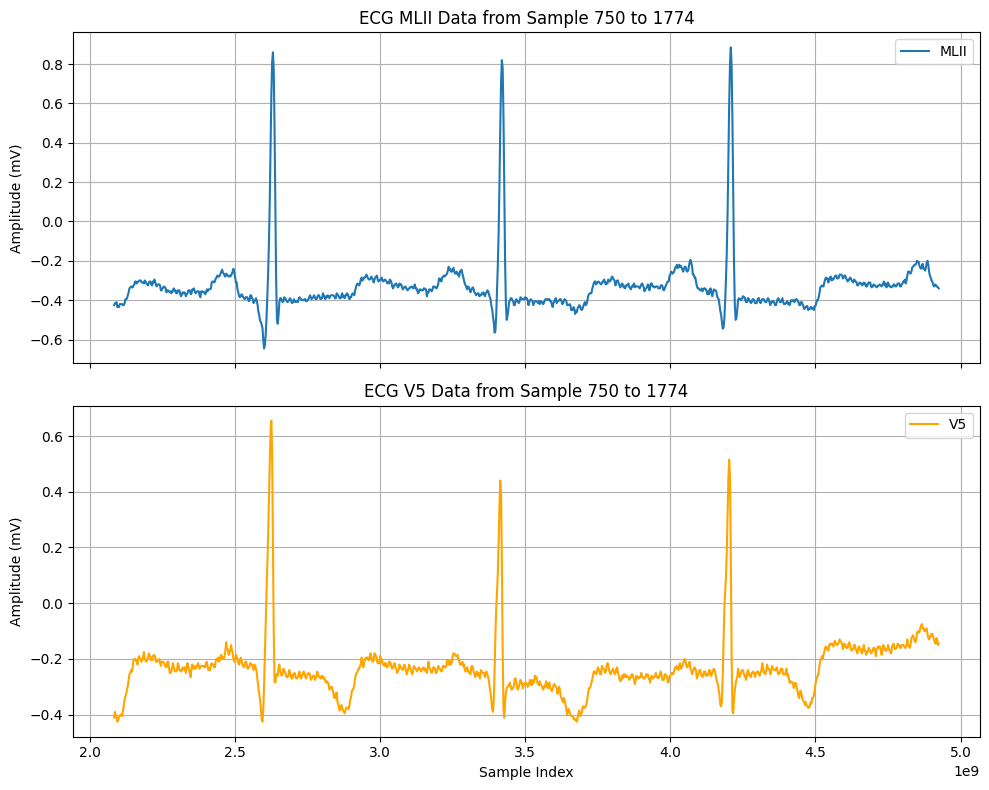

In [65]:
## Choose portion of record to work with
# REMINDER: sampling frequency is 360 Hz

# starting sample
start_sample = 750
# duration in seconds
num_samples = 1024

# Extract that portion of the signal only for the MLII samples
# Assuming you have already sliced the DataFrame to get the portion you're interested in

# Slicing the DataFrame for the MLII column
ecg_signal = df['MLII'].iloc[start_sample:start_sample + num_samples]

# Plot "duration" number of seconds of ecg data starting at "start" seconds
plot_ecg_interval(df, start_sample, num_samples) # Change the start and duration values as needed

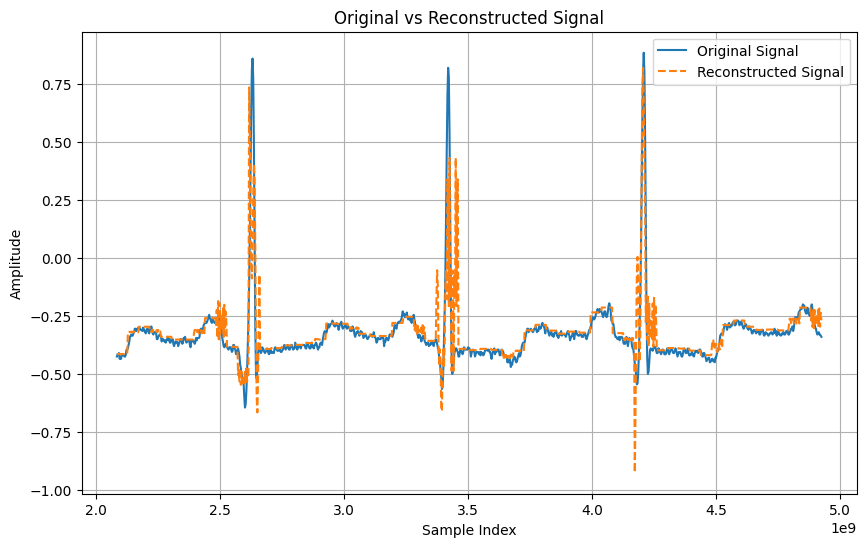

PRD (Percentage Root Mean Square Difference): 28.10%
SNR (Signal-to-Noise Ratio): 11.02 dB


(28.10316182587676, 11.024896316288228)

In [66]:
# Sampling phase
y, phi = compute_compressed_measurement(ecg_signal,16)

# Reconstruction phase
ecg_signal_reconstructed = reconstruct_signal(y, phi, alpha=0.1, max_iter=1000, transform_type='dct')
ecg_signal_reconstructed = pd.Series(ecg_signal_reconstructed, index=ecg_signal.index)

# Evaluation phase
plot_and_evaluate_reconstruction(ecg_signal, ecg_signal_reconstructed)